In [200]:
import numpy as np 
import pandas as pd 
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 

from sklearn import model_selection 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing # for scale

import pickle
import importlib

import finalproj as fp
import corinne

In [124]:
importlib.reload(fp)
importlib.reload(corinne)

<module 'corinne' from '/Users/andrewenfield/work/github/Data558/Kaggle/corinne.py'>

In [3]:
features_train = np.array(pickle.load(open('features_train', 'rb')))
labels_train = np.array(pickle.load(open('labels_train', 'rb')))
print(len(features_train), len(labels_train))

4320 4320


In [4]:
X_scaled = preprocessing.scale(features_train)
X_scaled.shape

(4320, 2048)

_Pick two classes of your choice from the dataset. Train an L2-regularized logistic regression classiﬁer on the training set using your own fast gradient algorithm with λ = 1. Plot, with diﬀerent colors, the misclassiﬁcation error on the training set and on the validation set vs iterations._

I'll pick 086, Pacific Loon, and 087, Mallard, as the two classes.

Per Zaid's answer on 5/27, in this problem I'm considering just the subset of the data that has these two classes. I pull the data and train/test a binary classifer. I only use the 60 observations for the two chosen birds.

In [5]:
indices_twoclasses = np.where((labels_train == '086.Pacific_Loon') | (labels_train == '087.Mallard'))
indices_twoclasses

(array([1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690,
        1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701,
        1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712,
        1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723,
        1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734,
        1735, 1736, 1737, 1738, 1739]),)

In [6]:
X_twoclasses = X_scaled[indices_twoclasses]
X_twoclasses.shape

(60, 2048)

In [7]:
y_twoclasses = np.where(labels_train[indices_twoclasses] == '086.Pacific_Loon', 1, -1)
y_twoclasses.shape

(60,)

In [105]:
def get_probability(logodds):
    return 1 / (1 + np.exp(-logodds))
    #return np.exp(logodds) / (1 + np.exp(logodds))

def get_accuracy(beta_coefs, X, y_actual, prob_threshold=0.5):
    """
    Return the classification accuracy given a set of coefficients, in 
    beta_coefs, and observations, in X, compared to actual/known values 
    in y_actual. The threshold parameter defines the value above which the
    predicted value is considered a positive example.
    """
    y_pred = X.dot(beta_coefs.T).ravel() # ravel to convert to vector
    
    # for logistic regression convert to a prob and use a prob threshold
    probs = get_probability(y_pred)
    y_thresholded = np.where(probs > prob_threshold, 1, -1)
    
    return accuracy_score(y_actual, y_thresholded)

In [106]:
X_twoclasses_train, X_twoclasses_test, y_twoclasses_train, y_twoclasses_test = model_selection.train_test_split(
    X_twoclasses, y_twoclasses, test_size=0.3)
X_twoclasses_train.shape, X_twoclasses_test.shape, y_twoclasses_train.shape, y_twoclasses_test.shape

((42, 2048), (18, 2048), (42,), (18,))

In [107]:
t_init = 0.01
max_iters = 100

In [184]:
results = fp.fastgradalgo(
    X_twoclasses_train, y_twoclasses_train, t_init=t_init, 
    grad_func = fp.compute_gradient_logistic_regression, 
    obj_func = fp.compute_objective_logistic_regression, 
    lam=1, max_iter=max_iters)
results[-3:]

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
98,-0.005872,0.000342,0.006093,-0.002024,-0.001537,-0.000813,-0.000144,0.000409,-0.000503,-0.001852,...,-0.002243,0.000742,0.003328,-0.006830,0.005815,0.003015,-0.006233,-0.006942,-0.001212,0.00187
99,-0.005872,0.000342,0.006093,-0.002024,-0.001536,-0.000813,-0.000145,0.000409,-0.000502,-0.001852,...,-0.002244,0.000742,0.003328,-0.006829,0.005815,0.003015,-0.006233,-0.006941,-0.001211,0.00187
100,-0.005872,0.000342,0.006092,-0.002023,-0.001536,-0.000813,-0.000145,0.000408,-0.000502,-0.001852,...,-0.002244,0.000742,0.003328,-0.006829,0.005815,0.003016,-0.006232,-0.006941,-0.001210,0.00187


In [109]:
# note use of the held out test data to get the performance metrics
accuracy = get_accuracy(fp.get_final_coefs(results), X_twoclasses_test, y_twoclasses_test)
print("Accuracy: {0:.1%}".format(accuracy))
print("Misclassification error: {0:.1%}".format(1 - accuracy))

Accuracy: 100.0%
Misclassification error: 0.0%


In [112]:
def get_objective_values(beta_results_df, X, y, lam):
    return beta_results_df.apply(lambda r: fp.compute_objective_logistic_regression(r.values, 
                                                    X, y, lam), axis=1)

In [113]:
obj_vals = pd.DataFrame({'Train': get_objective_values(results, X_twoclasses_train, y_twoclasses_train, 1),
              'Validation': get_objective_values(results, X_twoclasses_test, y_twoclasses_test, 1)})
obj_vals[:3]

,Train,Validation
0,0.693147,0.693147
1,0.177891,0.213812
2,0.134578,0.194154


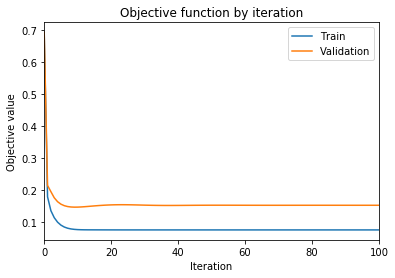

In [114]:
ax = obj_vals.plot()
ax.set_xlabel('Iteration')
ax.set_ylabel('Objective value')
ax.set_title('Objective function by iteration')

In [120]:
def get_misclassification_errors(beta_results_df, X, y):
    return beta_results_df.apply(lambda r: 1 - get_accuracy(r.values, X, y), axis=1)

In [121]:
errors = pd.DataFrame({'Train': get_misclassification_errors(results, X_twoclasses_train, y_twoclasses_train),
              'Validation': get_misclassification_errors(results, X_twoclasses_test, y_twoclasses_test)})
errors[:3]

,Train,Validation
0,0.547619,0.388889
1,0.000000,0.000000
2,0.023810,0.055556


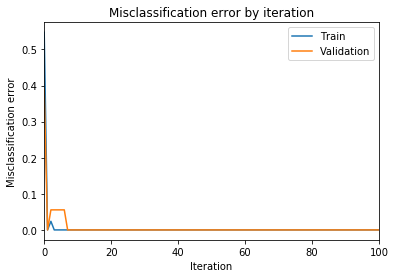

In [122]:
ax = errors.plot()
ax.set_xlabel('Iteration')
ax.set_ylabel('Misclassification error')
ax.set_title('Misclassification error by iteration')

## Corinne verification - using her code, do we see the same results?

In [248]:
results_corinne, thetas_corinne = corinne.fastgradalgo(np.zeros(X_train.shape[1]),
                                       np.zeros(X_train.shape[1]),
                                       1,
                                       0.01,
                                       100,
                                       X_train,
                                       y_train)
results_corinne.shape

Fast gradient iteration 100


(101, 2048)

In [250]:
results_corinne

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -1.99682301e-04,  -1.09313709e-04,  -8.02460742e-05, ...,
          1.23307473e-04,   3.67999397e-05,  -4.99477375e-05],
       [ -3.63295384e-04,  -2.16952494e-04,  -1.32288192e-04, ...,
          2.01673270e-04,   7.13951772e-05,  -7.15946903e-05],
       ..., 
       [ -4.01553603e-03,  -3.43040245e-03,   5.16718208e-04, ...,
          2.87920988e-05,   1.80055744e-03,   7.32757170e-04],
       [ -4.01596705e-03,  -3.43067501e-03,   5.18232219e-04, ...,
          2.96547532e-05,   1.80096975e-03,   7.33815025e-04],
       [ -4.01676438e-03,  -3.43110868e-03,   5.19754980e-04, ...,
          3.02342403e-05,   1.80128781e-03,   7.35009997e-04]])

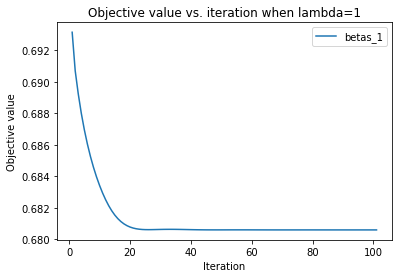

In [251]:
corinne.objective_plot(results_corinne, 1, X_train, y_train)

In [254]:
corinne.compute_misclassification_error(results_corinne[100,:], X_test, y_test)

0.47530864197530864

In [256]:
corinne.compute_misclassification_error(results.values[100,:], X_test, y_test)

0.47530864197530864

In [264]:
results_corinne[2,:]

array([ -3.63295384e-04,  -2.16952494e-04,  -1.32288192e-04, ...,
         2.01673270e-04,   7.13951772e-05,  -7.15946903e-05])

In [263]:
results.values[2, :]

array([ -3.63295384e-04,  -2.16952494e-04,  -1.32288192e-04, ...,
         2.01673270e-04,   7.13951772e-05,  -7.15946903e-05])

In [271]:
lambduh = 1
d = X_train.shape[1]
beta_init = np.zeros(d)
theta_init = np.zeros(d)
eta_init = 1/(scipy.linalg.eigh(1/len(y_train)*X_train.T.dot(X_train), 
                                eigvals=(d-1, d-1), eigvals_only=True)[0]+lambduh)
maxiter = 300
#betas_grad = corinne.graddescent(beta_init, lambduh, eta_init, maxiter, X_train, y_train)
betas_fastgrad, thetas_fastgrad = corinne.fastgradalgo(beta_init, theta_init, lambduh, eta_init, maxiter,
                                                       X_train, y_train)
betas_fastgrad.shape
#objective_plot(betas_grad, betas_fastgrad, lambduh, save_file='hw3_q1_part_h_output.png')


Fast gradient iteration 100
Fast gradient iteration 200
Fast gradient iteration 300


(301, 2048)

In [274]:
betas_fastgrad[-1:]

array([[ -4.03362426e-03,  -3.43958460e-03,   5.21826364e-04, ...,
          2.31106829e-05,   1.79956585e-03,   7.42056345e-04]])

In [275]:
corinne.compute_misclassification_error(betas_fastgrad[-1,:], X_test, y_test)

0.47530864197530864

Ok, so, bottom line, we get the same results from our code as we do from Corinne's code, even when we use the exact same setup/init code (for ex, that sets eta_init using X.T.dot(X)), and when we use Corinne's code that does backtracking compared to our code, above, where we're not using backtracking. I think this is good enough for me to accept that w/ a lambda of 1 at least, logistic regression is way worse than just returning negative all the time.

What do we see when we use our backtracking impl?

In [288]:
results = fp.fastgradalgo(
    X_train, y_train, t_init=t_init, 
    grad_func = fp.compute_gradient_logistic_regression, 
    obj_func = fp.compute_objective_logistic_regression, 
    lam=1, max_iter=100)
results[-3:]

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
98,-0.004016,-0.003430,0.000517,-0.000092,-0.001432,-0.000109,-0.001791,0.001266,0.002640,-0.000864,...,0.001409,-0.004484,-0.003668,0.000416,-0.000109,-0.002647,0.000518,0.000029,0.001801,0.000733
99,-0.004016,-0.003431,0.000518,-0.000092,-0.001434,-0.000111,-0.001790,0.001268,0.002640,-0.000864,...,0.001410,-0.004484,-0.003668,0.000417,-0.000110,-0.002646,0.000519,0.000030,0.001801,0.000734
100,-0.004017,-0.003431,0.000520,-0.000092,-0.001435,-0.000112,-0.001788,0.001270,0.002639,-0.000863,...,0.001411,-0.004483,-0.003669,0.000418,-0.000110,-0.002646,0.000520,0.000030,0.001801,0.000735


In [298]:
results = fp.fastgradalgo(
    X_train, y_train, t_init=t_init, 
    grad_func = fp.compute_gradient_logistic_regression, 
    obj_func = fp.compute_objective_logistic_regression, 
    lam=1, max_iter=300, t_func=fp.backtracking)
results[-3:]

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
298,-0.004036,-0.003443,0.000523,-0.000098,-0.001434,-0.000093,-0.001795,0.00128,0.002664,-0.000864,...,0.001422,-0.004515,-0.00369,0.00042,-0.000109,-0.002671,0.000507,0.000022,0.001799,0.000741
299,-0.004036,-0.003443,0.000523,-0.000098,-0.001434,-0.000093,-0.001795,0.00128,0.002664,-0.000864,...,0.001422,-0.004515,-0.00369,0.00042,-0.000109,-0.002671,0.000507,0.000022,0.001799,0.000741
300,-0.004036,-0.003443,0.000523,-0.000098,-0.001434,-0.000093,-0.001795,0.00128,0.002664,-0.000864,...,0.001422,-0.004515,-0.00369,0.00042,-0.000109,-0.002671,0.000507,0.000022,0.001799,0.000741


In [299]:
corinne.compute_misclassification_error(results.values[-1,:], X_test, y_test)

0.47530864197530864

In [300]:
1 - get_accuracy(results.values[-1,:], X_test, y_test)

0.47530864197530864

Ok, so we get the same results w/ our own backtracking implementation. Note again that since our stopping criteria is _only_ the number of iterations, we don't automatically get any benefit from the improved step sizes that backtracking gives us. That said, we still in theory could get to the minimum faster, which means if we're manually setting max_iter based on experimentation, then backtracking could help.

Finally, it's possible that backtracking adds enough processing time that we might want to run w/ it off if we're not going to use it. 

Although, backtracking might not _just_ give us better steps sizes leading to quicker convergence. It seems like it could also help us avoid the case where we _don't_ converge, if it keeps us from using a static/single step size that at some point means we're moving back and forth on our objective value without decreasing.

Bottom line, if i care, I should probably benchmark, and watch for non-convergence being fixed when we use backtracking. I'll keep that in mind.

Also, separately, it seems like my impl is way faster than Corinne's - I can run w/ 300 iterations in just a few secs while it takes her's well more than 10-20s it seems, anecdotally. It might be interesting to profile and see if a) this is really the case, and b) if so, why.

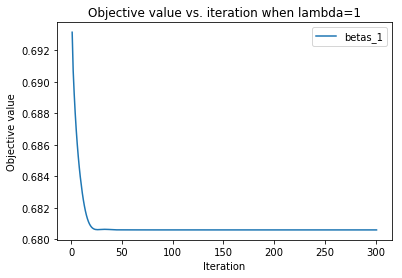

In [301]:
corinne.objective_plot(results.values, 1, X_train, y_train)

In [276]:
[fp.compute_objective_logistic_regression(coefs, X_train, y_train, 1) for coefs in results.values][:10]

[0.69314718055990943,
 0.69069840925813752,
 0.68923848668062204,
 0.68800550555072026,
 0.68695783810160649,
 0.68605473272573059,
 0.68526849901743814,
 0.68457882460233843,
 0.68396918396901918,
 0.68342703757035017]

_Find the value of the regularization parameter λ using cross-validation; you may use scikit-learn’s built-in functions for this purpose. Train an L2-regularized logistic regression classiﬁer on the training set using your own fast gradient algorithm with that value of λ found by cross-validation. Plot, with diﬀerent colors, the misclassiﬁcation error on the training set and on the validation set vs iterations._

In [225]:
importlib.reload(fp)
importlib.reload(corinne)

<module 'corinne' from '/Users/andrewenfield/work/github/Data558/Kaggle/corinne.py'>

In [132]:
lambdas = [10 ** exponent for exponent in range(-5,2)]
lambdas

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

In [137]:
lams, scores = fp.cross_validate(10, X_twoclasses_train, y_twoclasses_train, lambdas, max_iters=100)

In [138]:
list(zip(lams, scores))

[(1e-05, 1.0),
 (0.0001, 1.0),
 (0.001, 1.0),
 (0.01, 1.0),
 (0.1, 1.0),
 (1, 1.0),
 (10, 1.0)]

In [142]:
results_best = fp.fastgradalgo(
    X_twoclasses_train, y_twoclasses_train, t_init=t_init, 
    grad_func = fp.compute_gradient_logistic_regression, 
    obj_func = fp.compute_objective_logistic_regression, 
    lam=0, max_iter=max_iters)
results_best[-3:]

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
98,-0.015709,0.001152,0.015932,-0.004147,-0.002475,-0.004707,-0.002485,-0.001667,-0.002810,-0.005659,...,-0.006630,0.002924,0.009427,-0.021508,0.014287,0.008362,-0.015905,-0.019254,-0.000248,0.005101
99,-0.015748,0.001156,0.015973,-0.004156,-0.002473,-0.004727,-0.002499,-0.001682,-0.002818,-0.005674,...,-0.006650,0.002938,0.009457,-0.021571,0.014323,0.008388,-0.015942,-0.019308,-0.000231,0.005118
100,-0.015787,0.001159,0.016014,-0.004164,-0.002470,-0.004747,-0.002513,-0.001697,-0.002826,-0.005688,...,-0.006669,0.002952,0.009488,-0.021634,0.014358,0.008414,-0.015979,-0.019361,-0.000213,0.005135


In [148]:
fp.get_accuracy(fp.get_final_coefs(results_best), X_twoclasses_test, y_twoclasses_test)

1.0

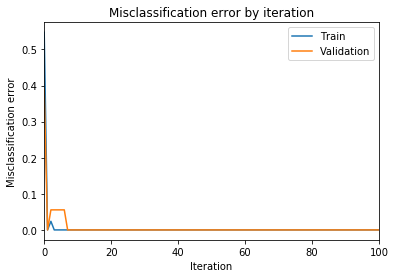

In [145]:
fp.plot_misclassification_errors_by_iteration(results_best, X_twoclasses_train, X_twoclasses_test, 
                                              y_twoclasses_train, y_twoclasses_test)

# Homework five

In [277]:
importlib.reload(fp)
importlib.reload(corinne)

<module 'corinne' from '/Users/andrewenfield/work/github/Data558/Kaggle/corinne.py'>

_Pick k = 5 classes of your choice from the dataset. You may choose any subset of 5 classes among all classes of the dataset._

_Write a function that, for any class at hand, creates a training set with an equal number of examples from the class at hand and from the other classes. You may simply randomly pick the examples from the other classes._

In [190]:
X_incl086, labels_incl086 = fp.get_balanced_set('086.Pacific_Loon', X_scaled, labels_train)
y_incl086 = np.where(labels_incl086 == '086.Pacific_Loon', 1, -1)
X_incl086.shape, y_incl086.shape

((60, 2048), (60,))

_For each class c, train an L2-regularized logistic regression classiﬁer using your own fast gradient algorithm with λc = 1. Display the confusion matrix. Which classes seem to be the most diﬃcult to classify?_

In [191]:
X_incl086_train, X_incl086_test, y_incl086_train, y_incl086_test = model_selection.train_test_split(
    X_incl086, y_incl086, test_size=0.3)
X_incl086_train.shape, X_incl086_test.shape, y_incl086_train.shape, y_incl086_test.shape

((42, 2048), (18, 2048), (42,), (18,))

In [193]:
results_incl086 = fp.fastgradalgo(
    X_incl086_train, y_incl086_train, t_init=t_init, 
    grad_func = fp.compute_gradient_logistic_regression, 
    obj_func = fp.compute_objective_logistic_regression, 
    lam=1, max_iter=max_iters)
results_incl086[-3:]

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
98,0.002500,-0.003663,0.003899,-0.010769,-0.002073,0.003407,0.004690,0.004321,-0.001964,0.000052,...,-0.009809,-0.002991,0.011609,0.000448,0.003338,-0.005294,0.00209,0.0085,0.001033,-0.001343
99,0.002499,-0.003663,0.003899,-0.010768,-0.002073,0.003407,0.004689,0.004320,-0.001963,0.000051,...,-0.009808,-0.002991,0.011608,0.000447,0.003338,-0.005293,0.00209,0.0085,0.001033,-0.001343
100,0.002499,-0.003664,0.003898,-0.010768,-0.002073,0.003408,0.004687,0.004319,-0.001962,0.000051,...,-0.009808,-0.002992,0.011606,0.000446,0.003338,-0.005292,0.00209,0.0085,0.001034,-0.001342


In [285]:
fp.get_accuracy(fp.get_final_coefs(results_incl086), X_incl086_test, y_incl086_test)

0.72222222222222221

In [298]:
list(zip(fp.get_y_pred(fp.get_final_coefs(results_incl086), X_incl086_test, y_incl086_test), y_incl086_test))

[(1, 1),
 (-1, -1),
 (1, -1),
 (1, 1),
 (1, -1),
 (-1, -1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (-1, -1),
 (1, 1),
 (1, -1),
 (1, -1),
 (1, 1),
 (-1, -1),
 (1, -1),
 (1, 1)]

In [278]:
confusion_matrix(y_incl086_test, fp.get_y_pred(fp.get_final_coefs(results_incl086), X_incl086_test, y_incl086_test), 
                 labels=[1,-1])

array([[9, 0],
       [5, 4]])

In [296]:
cm = fp.get_confusion_matrix(fp.get_final_coefs(results_incl086), X_incl086_test, y_incl086_test, 0.95)
cm

array([[9, 0],
       [1, 8]])

We need five classifiers, one for each label.

In [318]:
fp.get_final_coefs(results).ravel().shape

(2048,)

In [367]:
def get_classifier_for_label(classifier_label, X, labels, lam):
    X_incl_label, labels_incl_label = fp.get_balanced_set(classifier_label, X, labels)
    y_incl_label = np.where(labels_incl_label == classifier_label, 1, -1)
    
    X_sub_train, _, y_sub_train, _ = model_selection.train_test_split(
                                            X_incl_label, y_incl_label, test_size=0.3)
    
    results_incl_label = fp.fastgradalgo(
        X_sub_train, y_sub_train, t_init=t_init, 
        grad_func = fp.compute_gradient_logistic_regression, 
        obj_func = fp.compute_objective_logistic_regression, 
        lam=lam, max_iter=max_iters, t_func=fp.backtracking)

    return fp.get_final_coefs(results_incl_label).ravel() # return a vector instead of a 1-D array

In [368]:
foo = get_classifier_for_label('086.Pacific_Loon', X_scaled, labels_train, 1)
foo.shape

(2048,)

In [376]:
classifier_labels = ['086.Pacific_Loon','044.Frigatebird','095.Baltimore_Oriole',
                     '154.Red_eyed_Vireo','188.Pileated_Woodpecker']
classifiers = np.asarray([get_classifier_for_label(classifier_label, X_scaled, labels_train, 1) for 
                          classifier_label in classifier_labels])
classifiers.shape

(5, 2048)

In [377]:
predictions_by_classifier = classifiers.dot(X_scaled.T).T
predictions_by_classifier.shape

(4320, 5)

In [378]:
label_index_of_highest_prediction = np.argmax(predictions_by_classifier, 1)

In [379]:
predicted_labels = np.array([classifier_labels[index] for index in label_index_of_highest_prediction])
predicted_labels.shape

(4320,)

In [380]:
predicted_labels[:3]

array(['044.Frigatebird', '044.Frigatebird', '044.Frigatebird'], 
      dtype='<U23')

In [381]:
labels_train_six_classes = [label if label in classifier_labels else 'Other' for label in labels_train]
set(labels_train_six_classes)

{'044.Frigatebird',
 '086.Pacific_Loon',
 '095.Baltimore_Oriole',
 '154.Red_eyed_Vireo',
 '188.Pileated_Woodpecker',
 'Other'}

In [386]:
cm = confusion_matrix(labels_train_six_classes, predicted_labels)
cm

array([[  28,    0,    1,    0,    1,    0],
       [   3,   27,    0,    0,    0,    0],
       [   0,    0,   30,    0,    0,    0],
       [   0,    0,    0,   30,    0,    0],
       [   2,    0,    0,    0,   28,    0],
       [ 469,  523, 1074, 1058, 1046,    0]])

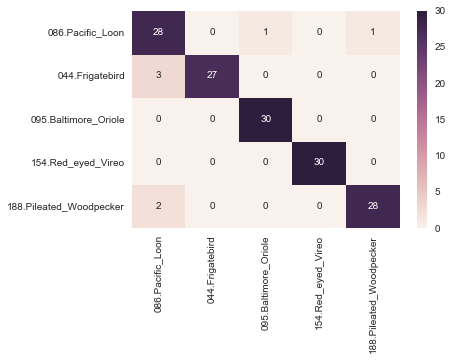

In [394]:
sns.heatmap(cm[:5,:5], annot=True, xticklabels=classifier_labels, yticklabels=classifier_labels)


In [336]:
4320*5*2048

44236800

**TODO** generalize to do this for a list

In [258]:
get_confusion_matrix_for_label('086.Pacific_Loon', X_scaled, labels_train)

(array([[6, 3],
        [0, 9]]), 0.83333333333333337)

**TODO** why do we always get a 0 in one corner? This means that we never have any false negatives - that is, we never predict -1 when it's actually 1. We do the other three. Why?

So, this means that we never predict that it ISN'T the bird in question, when it is actually the bird in question. I tried w/ an array of thresholds from very low to very high, and while they changed some true negatives to false positives, they never changed any prediction to a false negative. Perhaps this is something that's not uncommon when you have a single 1-vs-rest classifier? For example, that classifier tends to see anything at all that looks remotely like the bird in question as the bird in question (leading to true positives when it IS the bird, and false positives when it's not), but does not - generally, or at all? - think that the bird in question is actually NOT the bird in question. I could also write the above or add in terms of precision and recall if I thought about it for a few more minutes.

_Write a function that returns the ranked list of classes in terms of classiﬁcation diﬃculty using the confusion matrix. Compute the multi-class misclassiﬁcation error._

_Find the values of the regularization parameters λ1,...,λk for the classiﬁers using a hold-out validation set strategy. Deﬁne a grid of values Λ for each parameter λc with c = 1,...,k. For each setting of the regularization parameters λ1,...,λk, where each λc can take values in Λ (independently), train all your k = 5 classiﬁers and save the multi-class misclassiﬁcation error on the validation set for each setting of the regularization parameters λ1,...,λk._

_Find the optimal value of the regularization parameters λ1,...,λk based on the validation error. Display the confusion matrix for this setting of the regularization parameters._